<a href="https://colab.research.google.com/github/VesalAhsani/pytorch_Vision_Transformer/blob/main/pytorch_Vision_Transformer_(ViT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Transformer implementation in Pytorch

#### Originally, this notebook is a part of [*Deep Learning wih PyTorch*](https://github.com/VesalAhsani/Deep-learning-with-PyTorch) class I taught for grad students.

##### You can also find this notebook in [here](https://github.com/VesalAhsani/Deep-learning-with-PyTorch/blob/main/6_PyTorch_Transformers_ViT.ipynb).



# PyTorch Transformers

We're going to focus on recreating the Vision Transformer (ViT) computer vision architecture and applying it to our Food101 dataset to classify different images of pizza, steak and sushi.

* **ViT paper** - Short hand for the original machine learning research paper that introduced the ViT architecture, [*An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale*](https://arxiv.org/abs/2010.11929).

The Transformer neural network architecture was originally introduced in the machine learning research paper [*Attention is all you need*](https://arxiv.org/abs/1706.03762).

And the original Transformer architecture was designed to work on one-dimensional (1D) sequences of text.

A **Transformer architecture** is generally considered to be any neural network that uses the [**attention mechanism**](https://en.wikipedia.org/wiki/Attention_(machine_learning)) as its primary learning layer. Similar to a how a convolutional neural network (CNN) uses convolutions as its primary learning layer.

The original Vision Transformer has been through several iterations over the past couple of years, however, we're going to focus on replicating the original, otherwise known as the "vanilla Vision Transformer". Because if you can recreate the original, you can adapt to the others. 

## Where can you find code examples for machine learning research papers?

there are several places to find and read machine learning research papers (and code):

| **Resource** | **What is it?** |
| ----- | ----- |
| [arXiv](https://arxiv.org/) | Pronounced "archive", arXiv is a free and open resource for reading technical articles on everything from physics to computer science (inlcuding machine learning). | 
| [AK Twitter](https://twitter.com/ak92501) | The AK Twitter account publishes machine learning research highlights, often with live demos almost every day. I don't understand 9/10 posts but I find it fun to explore every so often. |
| [Papers with Code](https://paperswithcode.com/) | A curated collection of trending, active and greatest machine learning papers, many of which include code resources attached. Also includes a collection of common machine learning datasets, benchmarks and current state-of-the-art models. |
| [lucidrains' `vit-pytorch` GitHub repository](https://github.com/lucidrains/vit-pytorch) | Less of a place to find research papers and more of an example of what paper replicating with code on a larger-scale and with a specific focus looks like. The `vit-pytorch` repository is a collection of Vision Transformer model architectures from various research papers replicated with PyTorch code (much of the inspiration for this notebook was gathered from this repository). |

> **Note:** I only list a few places, the ones I use most frequently personally.

### Inputs and outputs, layers and blocks

ViT is a deep learning neural network architecture.

* **Layer** - takes an input, performs a function on it, returns an output.
* **Block** - a collection of layers, takes an input, performs a series of functions on it, returns an output.
* **Architecture (or model)** - a collection of blocks, takes an input, performs a series of functions on it, returns an output.


### What's ViT made of?


.


<img src="https://github.com/VesalAhsani/Deep-learning-with-PyTorch/raw/main/data/ViT.png" width=900 alt="figure 1 from the original vision transformer paper"/>

*Figure 1 from the ViT Paper showcasing the different inputs, outputs, layers and blocks that create the architecture.* 

The ViT architecture is comprised of several stages:
* **Patch + Position Embedding (inputs)** - Turns the input image into a sequence of image patches and add a position number what order the patch comes in.
* **Linear projection of flattened patches (Embedded Patches)** - The image patches get turned into an **embedding**, the benefit of using an embedding rather than just the image values is that an embedding is a *learnable* representation (typically in the form of a vector) of the image that can improve with training.
* **Norm** - This is short for "[Layer Normalization](https://paperswithcode.com/method/layer-normalization)" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer [`torch.nn.LayerNorm()`](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).
* **Multi-Head Attention** - This is a [Multi-Headed Self-Attention layer](https://paperswithcode.com/method/multi-head-attention) or "MSA" for short. You can create an MSA layer via the PyTorch layer [`torch.nn.MultiheadAttention()`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html).
* **MLP (or [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron))** - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a `forward()` method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two [`torch.nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers with a [`torch.nn.GELU()`](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) non-linearity activation in between them (section 3.1) and a [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) layer after each. 
* **Transformer Encoder** - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
* **MLP Head** - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.

#### Exploring Table 1 in the ViT paper



| Model | Layers | Hidden size $D$ | MLP size | Heads | Params |
| :--- | :---: | :---: | :---: | :---: | :---: |
| ViT-Base | 12 | 768 | 3072 | 12 | $86M$ |
| ViT-Large | 24 | 1024 | 4096 | 16 | $307M$ |
| ViT-Huge | 32 | 1280 | 5120 | 16 | $632M$ |

<div align=center>
    <i>Table 1: Details of Vision Transformer model variants. Source: <a href="https://arxiv.org/abs/2010.11929">ViT paper</a>.</i>
</div>
<br>

This table showcasing the various hyperparameters of each of the ViT architectures.

You can see the numbers gradually increase from ViT-Base to ViT-Huge.


Breaking the hyperparameters down:
* **Layers** - How many Transformer Encoder blocks are there? (each of these will contain a MSA block and MLP block)
* **Hidden size $D$** - This is the embedding dimension throughout the architecture, this will be the size of the vector that our image gets turned into when it gets patched and embedded. Generally, the larger the embedding dimension, the more information can be captured, the better results. However, a larger embedding comes at the cost of more compute.
* **MLP size** - What are the number of hidden units in the MLP layers?
* **Heads** - How many heads are there in the Multi-Head Attention layers?
* **Params** - What are the total number of parameters of the model? Generally, more parameters leads to better performance but at the cost of more compute. You'll notice even ViT-Base has far more parameters than any other model we've used so far.

We'll use these values as the hyperparameter settings for our ViT architecture. 

### 1: Split data into patches and creating the class, position and patch embedding 

**"it's all about the embedding."**

As in, if you can represent your data in a good, learnable way (as **embeddings are learnable representations**), chances are, a learning algorithm will be able to perform well on them.

We'll start with the **patch embedding**.

This means we'll be turning our input images in a sequence of patches and then embedding those patches.

Recall that an **embedding** is a learnable representation of some form and is often a vector. 

The term learnable is important because this means the numerical representation of an input image (that the model sees) can be improved over time.

> Training resolution is **224**.

Let's break down the text above.


* The image starts as 2D with size ${H \times W \times C}$.
    * $(H, W)$ is the resolution of the original image (height, width).
    * $C$ is the number of channels.
* The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.
    * $(P, P)$ is the resolution of each image patch (**patch size**).
    * $N=H W / P^{2}$ is the resulting number of patches, which also serves as the input sequence length for the Transformer.

input and output shapes of the patch embedding layer.

* **Input:** The image starts as 2D with size ${H \times W \times C}$.
* **Output:** The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

for an image size of 224 and patch size of 16:

* **Input (2D image):** (224, 224, 3) -> (height, width, color channels)
* **Output (flattened 2D patches):** (196, 768) -> (number of patches, embedding dimension)

### 2: Creating image patches with `torch.nn.Conv2d()`

By setting the `kernel_size` and `stride` parameters of a [`torch.nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) layer equal to the `patch_size`, we can effectively get a layer that splits our image into patches and creates a learnable embedding (referred to as a "Linear Projection" in the ViT paper) of each patch.


We can recreate these with:
* [`torch.nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) for turning our image into patches of CNN feature maps.
* [`torch.nn.Flatten()`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) for flattening the spatial dimensions of the feature map.

Let's start with the `torch.nn.Conv2d()` layer.

We can replicate the creation of patches by setting the `kernel_size` and `stride` equal to `patch_size`.

This means each convolutional kernel will be of size `(patch_size x patch_size)` or if `patch_size=16`, `(16 x 16)` (the equivalent of one whole patch).

And each step or `stride` of the convolutional kernel will be `patch_size` pixels long or `16` pixels long (equivalent of stepping to the next patch).

We'll set `in_channels=3` for the number of color channels in our image and we'll set `out_channels=768`, the same as the $D$ value in Table 1 for ViT-Base (this is the embedding dimension, each image will be embedded into a learnable vector of size 768).

### 3: Flattening the patch embedding with `torch.nn.Flatten()`

We've turned our image into patch embeddings but they're still in 2D format.

How do we get them into the desired output shape of the patch embedding layer of the ViT model?

* **Desried output (1D sequence of flattened 2D patches):** (196, 768) -> (number of patches, embedding dimension) -> ${N \times\left(P^{2} \cdot C\right)}$


we don't want to flatten the whole tensor, we only want to flatten the "spatial dimensions of the feature map".

Which in our case is the `feature_map_height` and `feature_map_width` dimensions of `image_out_of_conv`.

So how about we create a `torch.nn.Flatten()` layer to only flatten those dimensions, we can use the `start_dim` and `end_dim` parameters to set that up.

It looks like our `image_out_of_conv_flattened` shape is very close to our desired output shape: 
    
* **Desried output (flattened 2D patches):** (196, 768) -> ${N \times\left(P^{2} \cdot C\right)}$
* **Current shape:** (1, 768, 196)

The only difference is our current shape has a batch size and the dimensions are in a different order to the desired output.

We can do so with `torch.Tensor.permute()` just like we do when rearranging image tensors to plot them with matplotlib.

Beautiful!

We've turned our single 2D image into a 1D learnable embedding vector (or "Linear Projection of Flattned Patches" in Figure 1 of the ViT paper).

### 4: Create a class called `PatchEmbedding` 

which subclasses `nn.Module`. So it can be used a PyTorch layer.

In [ ]:
import torch
from torch import nn

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
class PatchEmbedding(nn.Module):
  """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
  def __init__(self, in_channels, patch_size, embedding_dim):
    super().__init__()

    # Create a layer to turn an image into patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)
    # Create a layer to flatten the patch feature maps into a single dimension, only flatten the feature map dimensions into a single vector
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

  def forward(self, x):
    x_flattened = self.flatten(self.patcher(x))
    return x_flattened.permute(0,2,1)

`PatchEmbedding` layer created!

Let's try it out on a single image.

In [ ]:
# Lets create a sample and see how it goes through the class
image = torch.randn(size=(3,224,224))

In [ ]:
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
patch_embedded_image.shape

torch.Size([1, 196, 768])

### 5: Let's create a learnable embedding for the class token.

To "prepend a learnable embedding to the sequence of embedded patches" we need to create a learnable embedding in the shape of the `embedding_dimension` ($D$) and then add it to the `number_of_patches` dimension. 

Or in pseudocode:

```python
patch_embedding = [image_patch_1, image_patch_2, image_patch_3...]
class_token = learnable_embedding
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)
```

Notice the concatenation (`torch.cat()`) happens on `dim=1` (the `number_of_patches` dimension).


To do so, we'll get the batch size and embedding dimension shape and then we'll create a `torch.randn()` tensor in the shape `[batch_size, 1, embedding_dimension]`.

And we'll make the tensor learnable by passing it to `nn.Parameter()` with `requires_grad=True`.

Now we've got the class token embedding, let's prepend it to our sequence of image patches, `patch_embedded_image`.

We can do so using [`torch.cat()`](https://pytorch.org/docs/stable/generated/torch.cat.html) and set `dim=1` (so `class_token`'s `number_of_tokens` dimension is preprended to `patch_embedded_image`'s `number_of_patches` dimension).

In [ ]:
# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
# [batch_size, number_of_tokens, embedding_dimension]
class_token = nn.Parameter(data = torch.randn(size=(patch_embedded_image.shape[0],1,patch_embedded_image.shape[-1])),
                           requires_grad=True)# make sure the embedding is learnable

# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_token = torch.cat((class_token, patch_embedded_image), dim=1) # concat on first dimension
patch_embedded_image_with_class_token.shape

torch.Size([1, 197, 768])

### 6: Creating the position embedding 

Now, it's time to create the position embedding.

> Position embeddings are added to the patch embeddings to retain positional information. We use **standard learnable 1D position embeddings**, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4 in the ViT paper). The resulting sequence of embedding vectors serves as input to the encoder.


This positional information can be important when considering what's in an image (without positional information an a flattened sequence could be seen as having no order and thus no patch relates to any other patch). 

In [ ]:
number_of_patches = 196
embedding_dimension = 768
# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.randn(size=(1, number_of_patches+1, embedding_dimension)),
                                  requires_grad=True)
print(f"position embedding shape: {position_embedding.shape}")

position embedding shape: torch.Size([1, 197, 768])


In [ ]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_token + position_embedding
print(patch_and_position_embedding)
print(f"patch and position embedding shape: {patch_and_position_embedding.shape}")

tensor([[[-1.6082, -2.3411,  1.1723,  ...,  0.5226, -0.7927, -0.4866],
         [ 0.0233, -0.0711,  1.1868,  ..., -0.5499,  0.7363,  1.5880],
         [-2.1530, -0.9904,  1.4777,  ...,  0.5498, -0.8582,  2.3165],
         ...,
         [-1.4119,  0.8610, -0.7236,  ..., -0.9570,  0.3287, -0.4909],
         [-1.1944,  0.3089,  1.8117,  ..., -0.7447,  1.6230, -2.2260],
         [ 0.7444, -0.6701, -0.9575,  ..., -0.8970,  1.3023,  1.7986]]],
       grad_fn=<AddBackward0>)
patch and position embedding shape: torch.Size([1, 197, 768])


### 7: Putting it all together: from image to embedding


1. Setting the patch size (we'll use `16` as it's widely used throughout the paper and for ViT-Base).
2. Getting a single image, printing its shape and storing its height and width.
3. Adding a batch dimension to the single image so it's compatible with our `PatchEmbedding` layer.
4. Creating a `PatchEmbedding` layer with a `patch_size=16` and `embedding_dim=768` (from Table 1 for ViT-Base).
5. Passing the single image through the `PatchEmbedding` layer in 4 to create a sequence of patch embeddings.
6. Creating a class token embedding. 
7. Prepending the class token emebdding to the patch embeddings created in step 5.
8. Creating a position embedding.
9. Adding the position embedding to the class token and patch embeddings created in step 7.


In [ ]:
def set_seeds():
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)

In [ ]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create a class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.randn(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Multi-Head Self-Attention (MSA)

We've got our input data patchified and embedded, now let's move onto the next part of the ViT architecture.

Many layers you find in research papers are already implemented in modern deep learning frameworks such as PyTorch.

In saying this, to replicate these layers and residual connection with PyTorch code we can use:
* **Multi-Head Self Attention (MSA)** - [`torch.nn.MultiheadAttention()`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html). 
* **Norm (LN or LayerNorm)** - [`torch.nn.LayerNorm()`](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).
* **Residual connection** - add the input to output. 

### 1: The LayerNorm (LN) layer

[Layer Normalization](https://paperswithcode.com/method/layer-normalization) (`torch.nn.LayerNorm()` or Norm or LayerNorm or LN) normalizes an input over the last dimension.


PyTorch's `torch.nn.LayerNorm()`'s main parameter is `normalized_shape` which we can set to be equal to the dimension size we'd like to noramlize over (in our case it'll be $D$ or `768` for ViT-Base).

What does it do?

Layer Normalization helps improve training time and model generalization (ability to adapt to unseen data).

I like to think of any kind of normalization as "getting the data into a similar format" or "getting data samples into a similar distribution".

Neural networks can optimize over data samples with similar distributions (similar mean and standard-deviations) easier than those with varying distributions. 

### 2: The Multi-Head Self Attention (MSA) layer 

The power of the self-attention and multi-head attention (self-attention applied multiple times) were revealed in the form of the original Transformer architecture introduced in the [*Attention is all you need*](https://arxiv.org/abs/1706.03762) research paper.

Originally designed for text inputs, the original self-attention mechanism takes a sequence of words and then calculates which word should pay more "attention" to another word.

In other words, in the sentence "the dog jumped over the fence", perhaps the word "dog" relates strongly to "jumped" and "fence".


Since our input is a sequence of image patches now, self-attention and in turn multi-head attention will calculate which patch of an image is most related to another patch, eventually forming a learned representation of an image. 

But what's most important is that the layer does this on it's own given the data (we don't tell it what patterns to learn).



The figure of the ViT architecture at the beginning of notebook above indicates the triple embedding input to the MSA layer.

This is known as **query, key, value** input or **qkv** for short which is fundamental to the self-attention mechanism.

In our case, the triple embedding input will be three versions of the output of the Norm layer, one for query, key and value.

Or three versions of our layer-normalized image patch and position embeddings.

We can implement the MSA layer in PyTorch with `torch.nn.MultiheadAttention()` with the parameters:
* `embed_dim` - the embedding dimension from Table 1 (Hidden size $D$).
* `num_heads` - how many attention heads to use (this is where the term "multihead" comes from), this value is also in Table 1 (Heads).
* `dropout` - whether or not to apply dropout to the attention layer (according to Appendix B.1, dropout isn't used after the qkv-projections). 
* `batch_first` - our batch dimension comes first.

1. Create a class called `MultiheadSelfAttentionBlock` that inherits from `torch.nn.Module`.
2. Initialize the class with hyperparameters from Table 1 of the ViT paper for the ViT-Base model.
3. Create a layer normalization (LN) layer with `torch.nn.LayerNorm()` with the `normalized_shape` parameter the same as our embedding dimension ($D$ from Table 1).
4. Create a multi-head attention (MSA) layer with the appropriate `embed_dim`, `num_heads`, `dropout` and `batch_first` parameters.
5. Create a `forward()` method for our class passing the in the inputs through the LN layer and MSA layer.

In [ ]:
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    def __init__(self,
                 embedding_dim, # Hidden size D from Table 1 for ViT-Base
                 num_heads, # Heads from Table 1 for ViT-Base
                 attn_dropout): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
        
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, attn_output_weight = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False)
        return attn_output

In [ ]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


## The MLP block

The term [MLP](https://en.wikipedia.org/wiki/Multilayer_perceptron) is quite broad as it can refer to almost any combination of *multiple* layers (hence the "multi" in multilayer perceptron).

But it generally follows the pattern of: 

`linear layer -> non-linear layer -> linear layer -> non-linear layer`

In the the case of the ViT paper, the MLP contains two layers with a GELU non-linearity.

Where "two layers" refers to linear layers ([`torch.nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) in PyTorch) and "GELU non-linearity" is the GELU  (Gaussian Error Linear Units) non-linear activation function ([`torch.nn.GELU()`](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) in PyTorch).

> **Note:** A linear layer (`torch.nn.Linear()`) can sometimes also be referred to as a "dense layer" or "feedforward layer". 

> Dropout is applied **after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings.**

This means that every linear layer (or dense layer) in the MLP block has a dropout layer ([`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) in PyTorch).

The value of dropout based on the paper (for ViT-Base, `dropout=0.1`).

Knowing this, the structure of our MLP block will be:

`layer norm -> linear layer -> non-linear layer -> dropout -> linear layer -> dropout`


In [ ]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size, # MLP size from Table 1 for ViT-Base
                 dropout):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )
    
    def forward(self, x):
      return self.mlp(self.layer_norm(x))

In [ ]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1 
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_mlp_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


## Create the Transformer Encoder 

### All by ourselves from scratch

In deep learning, an ["encoder" or "auto encoder"](https://paperswithcode.com/method/autoencoder) generally refers to a stack of layers that "encodes" an input (turns it into some form of numerical representation).

In our case, the Transformer Encoder will encode our patched image embedding into a learned representation using a series of alternating layers of MSA blocks and MLP blocks:

> The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA) and MLP blocks. **Layernorm (LN) is applied before every block**, and **residual connections after every block** (Wang et al., 2019; Baevski & Auli, 2019).

what about the residual connections?

[Residual connections](https://paperswithcode.com/method/residual-connection) (also called skip connections), were first introduced in the paper [*Deep Residual Learning for Image Recognition*](https://arxiv.org/abs/1512.03385v1) and are achieved by adding a layer(s) input to its subsequent output.

In the case of the ViT architecture, the residual connection means the input of the MSA block is added back to the output of the MSA block before it passes to the MLP block and the same thing happens with the MLP block before it goes onto the next Transformer Encoder block.


`x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...`

What is the point of this?

One of the main ideas behind residual connections is that they prevent weight values and gradient updates from getting too small and thus allow deeper networks and in turn allow deeper representations to be learned.

> **Note:** The iconic computer vision architecture "ResNet" is named so because of the introduction of *res*idual connections. You can find many pretrained versions of ResNet architectures in [`torchvision.models`](https://pytorch.org/vision/stable/models.html). 

In [ ]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self, embedding_dim, num_heads, attn_dropout, mlp_size, mlp_dropout):
    super().__init__()

    self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout = attn_dropout)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)
    
  def forward(self, x):
    # Create residual connection for MSA block (add the input to the output)
    x = x + self.msa_block(x)
    # Create residual connection for MLP block (add the input to the output)
    x = x + self.mlp_block(x)
    
    return x

For ViT-Base, we'll be stacking together 12 of these Transformer Encoder blocks to form the backbone of our architecture.

Let's get a `torchinfo.summary()` of passing an input of shape `(1, 197, 768) -> (batch_size, num_patches, embedding_dimension)` to our Transformer Encoder block.

In [ ]:
!pip install torchinfo
from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock(768,12,0,3072,0.1)

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

> **Note:** Just because our input to the Transformer Encoder block has the same shape at the output of the block doesn't mean the values weren't manipulated, the whole goal of the Transformer Encoder block (and stacking them together) is to learn a deep representation of the input using the various layers in between.

### Creating a Transformer Encoder with PyTorch's Transformer layers 

So far we've built the components of and the Transformer Encoder layer itself ourselves.

But because of their rise in popularity and effectiveness, PyTorch now has in-built [Transformer layers as part of `torch.nn`](https://pytorch.org/docs/stable/nn.html#transformer-layers). 

For example, we can recreate the `TransformerEncoderBlock` we just created using [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) and setting the same hyperparameters as above.

 > Finally, since the ViT architecture uses several Transformer Layers stacked on top of each for the full architecture (Table 1 shows 12 Layers in the case of ViT-Base), you can do this with [`torch.nn.TransformerEncoder(encoder_layer, num_layers)`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder) where:
* `encoder_layer` - The target Transformer Encoder layer created with `torch.nn.TransformerEncoderLayer()`.
* `num_layers` - The number of Transformer Encoder layers to stack together.

In [ ]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

In [ ]:
torch_transformer_encoder = nn.TransformerEncoder(encoder_layer=torch_transformer_encoder_layer,
                                                  num_layers=12) 

In [ ]:
# # Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

## Putting everything together to create ViT

We're going to combine all of the blocks we've created to replicate the full ViT architecture.



In [ ]:
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224, # Training resolution
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:int=0, # Dropout for attention projection
                 mlp_dropout:int=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:int=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!
        
        # Make the image size is divisble by the patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        # Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # Create Transformer Encoder blocks 
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=torch_transformer_encoder_layer,
                                                  num_layers=12)
       
        # Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    

    def forward(self, x):
        
        # Get batch size
        batch_size = x.shape[0]
        # so far we set the batch size equal to 1. but in reality, it can be whatever; thus it is important to expand input dimension over batch size.
        # Create class token embedding and expand it to match the batch size
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # Create patch embedding
        x = self.patch_embedding(x)

        # Concat class embedding and patch embedding
        x = torch.cat((class_token, x), dim=1)

        # Add position embedding to patch embedding
        x = self.position_embedding + x

        # Run embedding dropout 
        x = self.embedding_dropout(x)

        # Pass patch, position and class embedding through transformer encoder layers
        x = self.transformer_encoder(x)

        # Put 0 index logit through classifier
        x = self.classifier(x[:,0]) # run on each sample in a batch at 0 index

        return x       

In [ ]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}") 
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


Notice how the first dimension gets expanded to the batch size and the other dimensions stay the same (because they're inferred by the "`-1`" dimensions in `.expand(batch_size, -1, -1)`).


In [ ]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(224,3,16,12,768,3072,12,0,0.1,0.1,3)

# Pass the random image tensor to our ViT instance
# vit(random_image_tensor)

Outstanding!

It looks like our random image tensor made it all the way through our ViT architecture and it's outputting three logit values (one for each class).

And because our `ViT` class has plenty of parameters we could customize the `img_size`, `patch_size` or `num_classes` if we wanted to.

### Visual summary of our ViT model

We handcrafted our own version of the ViT architecture and seen that a random image tensor can flow all the way through it.

We use `torchinfo.summary()` to get a visual overview of the input and output shapes of all the layers in our model.

In [ ]:
from torchinfo import summary

# # Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                               [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                      [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                 [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                           [32, 197, 768]       [32, 197, 768]       --                   --
├─TransformerEncoder (transformer_encoder)              [32, 197, 768]       [32, 197, 768]       --                   True
│    └─ModuleList (layers)                              --                   --                   --                   True
│    │ 



Checkout the total number of parameters too, 85,800,963, our biggest model yet!

The number is very close to PyTorch's pretrained ViT-Base with patch size 16 at [`torch.vision.models.vit_b_16()`](https://pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16) with 86,567,656 total parameters (though this number of parameters is for the 1000 classes in ImageNet).

> **Exercise:** Try changing the `num_classes` parameter of our `ViT()` model to 1000 and then creating another summary with `torchinfo.summary()` and see if the number of parameters lines up between our code and `torchvision.models.vit_b_16()`.

## Train our ViT model


### Creating an optimizer


> **Training & Fine-tuning.** We train all models, including ResNets, using Adam (Kingma & Ba, 2015 ) with $\beta_{1}=0.9, \beta_{2}=0.999$, a batch size of 4096 and apply a high weight decay of $0.1$, which we found to be useful for transfer of all models (Appendix D.1 shows that, in contrast to common practices, Adam works slightly better than SGD for ResNets in our setting).

So we can see they chose to use the "Adam" optimizer ([`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)) rather than SGD (stochastic gradient descent, [`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)).

The authors set Adam's $\beta$ (beta) values to $\beta_{1}=0.9, \beta_{2}=0.999$, these are the default values for the `betas` parameter in `torch.optim.Adam(betas=(0.9, 0.999))`.

They also state the use of [weight decay](https://paperswithcode.com/method/weight-decay) (slowly reducing the values of the weights during optimization to prevent overfitting), we can set this with the `weight_decay` parameter in `torch.optim.Adam(weight_decay=0.1)`.

And as discussed previously, we're going to use a lower batch size than 4096 due to hardware limitations (if you have a large GPU, feel free to increase this).

### Creating a loss function

we'll use [`torch.nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

### Training our ViT model



In [ ]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=1e-3, 
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper
                             weight_decay=0.1) # from the ViT paper section 4.1 (Training & Fine-tuning)

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
from pathlib import Path
from zipfile import ZipFile
import os

Path("data").mkdir(parents=True, exist_ok=True)

with open("data/food101_pizza_steak_sushi.zip", "wb") as f:
  import requests
  request = requests.get("https://github.com/VesalAhsani/Deep-learning-with-PyTorch/raw/main/data/food101_pizza_steak_sushi.zip")
  f.write(request.content)


with ZipFile("data/food101_pizza_steak_sushi.zip", "r") as zip_ref:
  zip_ref.extractall("data/food101_pizza_steak_sushi")

os.remove("data/food101_pizza_steak_sushi.zip")

In [ ]:
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader

train_dir = "data/food101_pizza_steak_sushi/train"
test_dir = "data/food101_pizza_steak_sushi/test"

auto_transform = torchvision.models.EfficientNet_B0_Weights.DEFAULT.transforms()

train_dataset = datasets.ImageFolder(root=train_dir, transform=auto_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=auto_transform)

BATCH_SIZE=32
NUM_WORKERS = 1
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS,
                              )
test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS,
                              )

In [ ]:
!pip install torchmetrics
from torchmetrics import Accuracy
accuracy_fn = Accuracy().to(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def train_step(model, dataloader, loss_fn, accuracy_fn, optimizer, device):
  model.train()
  train_loss, train_acc = 0, 0

  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

def test_step(model, dataloader, loss_fn, accuracy_fn, device):
  model.eval()
  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      loss = loss_fn(test_pred, y)
      test_loss += loss
      test_acc += accuracy_fn(test_pred, y)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

def train(model, train_dataloader, test_dataloader, loss_fn, accuracy_fn, optimizer, epochs, device):
  from tqdm.auto import tqdm

  results = {"train_loss":[],
             "train_acc":[],
             "test_loss":[],
             "test_acc":[]
             }
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model, train_dataloader, loss_fn, accuracy_fn, optimizer, device)
    test_loss, test_acc = test_step(model, test_dataloader, loss_fn, accuracy_fn, device)
  
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} train_acc: {train_acc:.2f}% | test_loss: {test_loss:.4f} test_acc: {test_acc:.2f}%")

  return results

In [ ]:
set_seeds()
results = train(vit, train_dataloader, test_dataloader, loss_fn, accuracy_fn, optimizer, 5, device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.4362 train_acc: 0.31% | test_loss: 1.7152 test_acc: 0.27%
Epoch: 2 | train_loss: 1.4376 train_acc: 0.40% | test_loss: 2.3556 test_acc: 0.26%
Epoch: 3 | train_loss: 1.4850 train_acc: 0.36% | test_loss: 2.0678 test_acc: 0.26%
Epoch: 4 | train_loss: 1.7063 train_acc: 0.33% | test_loss: 2.4778 test_acc: 0.20%
Epoch: 5 | train_loss: 1.5202 train_acc: 0.30% | test_loss: 1.6918 test_acc: 0.26%


### Investigation!

The original ViT architecture achieves good results on several image classification benchmarks.

The original ViT paper uses a far larger amount of data than ours (in deep learning, more data is generally always a good thing) and a longer training schedule (see Table 3).

| **Hyperparameter value** | **ViT Paper** | **Our implementation** |
| ----- | ----- | ----- |
| Number of training images | 1.3M (ImageNet-1k), 14M (ImageNet-21k), 303M (JFT) | 225 |
| Epochs | 7 (for largest dataset), 90, 300 (for ImageNet) | 10 | 
| Batch size | 4096 | 32 |
| [Learning rate warmup](https://paperswithcode.com/method/linear-warmup) | 10k steps (Table 3) | None | 
| [Learning rate decay](https://medium.com/analytics-vidhya/learning-rate-decay-and-methods-in-deep-learning-2cee564f910b#:~:text=Learning%20rate%20decay%20is%20a,help%20both%20optimization%20and%20generalization.) | Linear/Cosine (Table 3) | None | 
| [Gradient clipping](https://paperswithcode.com/method/gradient-clipping) | Global norm 1 (Table 3) | None |



Because of the size of the ViT architecture and its high number of parameters (increased learning capabilities), and amount of data it uses (increased learning opportunities), many of the techniques used in the ViT paper training scheme such as learning rate warmup, learning rate decay and gradient clipping are specifically designed to [prevent overfitting](https://www.learnpytorch.io/04_pytorch_custom_datasets/#81-how-to-deal-with-overfitting) (regularization). 


## Using a pretrained ViT from `torchvision.models` 


In [ ]:
# The following requires torch v0.12+ and torchvision v0.13+
import torch
import torchvision
print(torch.__version__) 
print(torchvision.__version__)

1.12.1+cu113
0.13.1+cu113


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Finally, we'll get the pretrained ViT-Base with patch size 16 from `torchvision.models` and prepare it for our dataset by turning it into a feature extractor transfer learning model.

Specifically, we'll:
1. Get the pretrained weights for ViT-Base trained on ImageNet-1k from [`torchvision.models.ViT_B_16_Weights.DEFAULT`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.ViT_B_16_Weights) (`DEFAULT` stands for best available).
2. Setup a ViT model instance via `torchvision.models.vit_b_16`, pass it the pretrained weights step 1 and send it to the target device.
3. Freeze all of the parameters in the base ViT model created in step 2 by setting their `requires_grad` attribute to `False`. 
4. Update the classifier head of the ViT model created in step 2 to suit our own problem by changing the number of `out_features` to our number of classes (pizza, steak, sushi). 


In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=3).to(device)
# pretrained_vit # uncomment for model output 

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

Pretrained ViT feature extractor model created!

Let's now check it out by printing a `torchinfo.summary()`.

In [ ]:
# # Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

The total number of parameters, 85,800,963, is the same as our custom made ViT model above.

But the number of trainable parameters for `pretrained_vit` is much, much lower than our custom `vit` at only 2,307 compared to 85,800,963 (in our custom `vit`, since we're training from scratch, all parameters are trainable). 

This means the pretrained model should train a lot faster, we could potentially even use a larger batch size since less parameter updates are going to be taking up memory.

Remember, if you're going to use a pretrained model, it's generally important to **ensure your own custom data is transformed/formatted in the same way the data the original model was trained on**. 

### Train feature extractor ViT model 


In [ ]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

from torchmetrics import Accuracy
accuracy_fn = Accuracy().to(device)

train_dir = "data/food101_pizza_steak_sushi/train"
test_dir = "data/food101_pizza_steak_sushi/test"

auto_transform = torchvision.models.ViT_B_16_Weights.DEFAULT.transforms()

train_dataset = datasets.ImageFolder(root=train_dir, transform=auto_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=auto_transform)

BATCH_SIZE=32
NUM_WORKERS = 1
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS,
                              )
test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS,
                              )

def train_step(model, dataloader, loss_fn, accuracy_fn, optimizer, device):
  model.train()
  train_loss, train_acc = 0, 0

  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

def test_step(model, dataloader, loss_fn, accuracy_fn, device):
  model.eval()
  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      loss = loss_fn(test_pred, y)
      test_loss += loss
      test_acc += accuracy_fn(test_pred, y)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

def train(model, train_dataloader, test_dataloader, loss_fn, accuracy_fn, optimizer, epochs, device):
  from tqdm.auto import tqdm

  results = {"train_loss":[],
             "train_acc":[],
             "test_loss":[],
             "test_acc":[]
             }
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model, train_dataloader, loss_fn, accuracy_fn, optimizer, device)
    test_loss, test_acc = test_step(model, test_dataloader, loss_fn, accuracy_fn, device)
  
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} train_acc: {train_acc:.2f}% | test_loss: {test_loss:.4f} test_acc: {test_acc:.2f}%")

  return results

In [ ]:
set_seeds()
results = train(pretrained_vit, train_dataloader, test_dataloader, loss_fn, accuracy_fn, optimizer, 10, device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7665 train_acc: 0.72% | test_loss: 0.5432 test_acc: 0.87%
Epoch: 2 | train_loss: 0.3428 train_acc: 0.95% | test_loss: 0.3263 test_acc: 0.90%
Epoch: 3 | train_loss: 0.2064 train_acc: 0.95% | test_loss: 0.2707 test_acc: 0.91%
Epoch: 4 | train_loss: 0.1556 train_acc: 0.96% | test_loss: 0.2422 test_acc: 0.91%
Epoch: 5 | train_loss: 0.1246 train_acc: 0.97% | test_loss: 0.2279 test_acc: 0.90%
Epoch: 6 | train_loss: 0.1216 train_acc: 0.98% | test_loss: 0.2129 test_acc: 0.93%
Epoch: 7 | train_loss: 0.0938 train_acc: 0.98% | test_loss: 0.2352 test_acc: 0.89%
Epoch: 8 | train_loss: 0.0797 train_acc: 0.98% | test_loss: 0.2281 test_acc: 0.88%
Epoch: 9 | train_loss: 0.1098 train_acc: 0.99% | test_loss: 0.2074 test_acc: 0.94%
Epoch: 10 | train_loss: 0.0650 train_acc: 0.99% | test_loss: 0.1804 test_acc: 0.92%


### Plot feature extractor ViT model loss curves

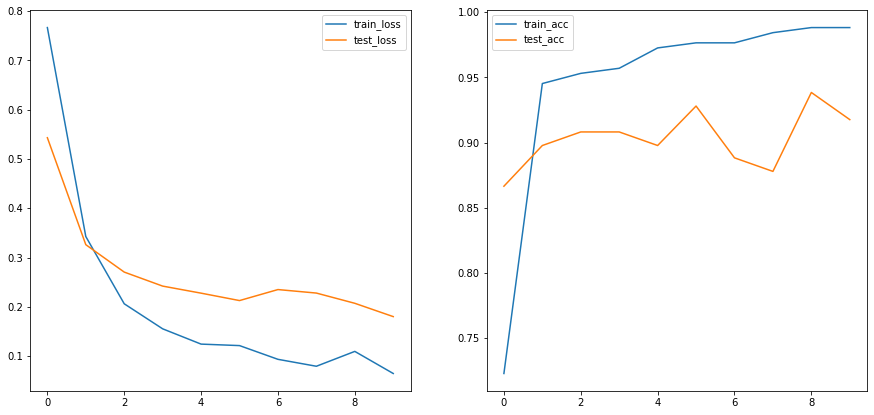

In [ ]:
# Let's plot loss curves
import matplotlib.pyplot as plt
import numpy as np

train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]
for i in range(len(results["train_loss"])):
  tr_loss = results["train_loss"][i].cpu().detach().numpy().item()
  tr_acc = results["train_acc"][i].cpu().detach().numpy().item()
  te_loss = results["test_loss"][i].cpu().detach().numpy().item()
  te_acc = results["test_acc"][i].cpu().detach().numpy().item()

  train_loss.append(tr_loss)
  train_acc.append(tr_acc)
  test_loss.append(te_loss)
  test_acc.append(te_acc)

epochs = range(len(results["train_loss"]))

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label = "train_loss")
plt.plot(epochs, test_loss, label = "test_loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, train_acc, label = "train_acc")
plt.plot(epochs, test_acc, label = "test_acc")
plt.legend();

### Save feature extractor ViT model and check file size


In [ ]:
from pathlib import Path

def save(model, save_path):
  """
  save_path should include .pth or .pt at the end.
  """  
  torch.save(obj=model.state_dict(),
             f=save_path)

In [ ]:
Path("models").mkdir(parents=True, exist_ok=True)
save(model=pretrained_vit,
           save_path = "models/pretrained_vit_16_food101_sample.pth")

And since we're thinking about deploying this model, it'd be good to know the size of it (in megabytes or MB).

We can check the size of our model in bytes using the `st_size` attribute of Python's [`pathlib.Path().stat()`](https://docs.python.org/3/library/pathlib.html#pathlib.Path.stat) method whilst passing it our model's filepath name. 

We can then scale the size in bytes to megabytes.

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/pretrained_vit_16_food101_sample.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB




How does this compare to the EffNetB2 feature extractor model in [05. PyTorch Experiment Tracking](https://github.com/VesalAhsani/Deep-learning-with-PyTorch/blob/main/05_PyTorch_Experiment_Tracking.ipynb)?

| **Model** | **Model size (MB)** | **Test loss** | **Test accuracy** | 
| ----- | ----- | ----- | ------ |
| EffNetB2 feature extractor | 29 | ~0.5157 | ~0.92 | 
| ViT feature extractor | 327 | ~0.1804 | ~0.92 | 


The EffNetB2 model is ~11x smaller than the ViT model with similiar results for test accuracy; but different for test loss.

But in terms of deployment, if we were comparing these two models, something we'd need to consider is whether the extra accuracy from the ViT model is worth the ~11x increase in model size? 

Perhaps such a large model would take longer to load/run and wouldn't provide as good an experience as EffNetB2 which performs similarly but at a much reduced size.

##  Make predictions on a custom image


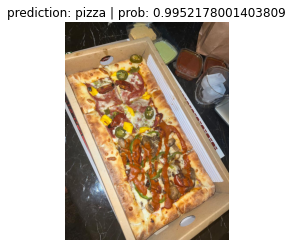

In [ ]:
with open("data/custom.jpeg", "wb") as f:
  import requests
  request = requests.get("https://github.com/VesalAhsani/Deep-learning-with-PyTorch/raw/main/data/custom.jpeg")
  f.write(request.content)

import random
from PIL import Image

def pred_and_plot(model, image, transform, device):

  img = Image.open(image)
  class_names= train_dataset.classes
  model.eval()
  with torch.inference_mode():
    y_logit = model(transform(img).unsqueeze(dim=0).to(device))
    y_pred = torch.softmax(y_logit, dim=1)
    y_prob = torch.argmax(y_pred)
  
  plt.figure()
  plt.imshow(img)
  plt.title(f"prediction: {class_names[y_prob]} | prob: {y_pred.max()}")
  plt.axis(False)

pred_and_plot(model=pretrained_vit,
              image="data/custom.jpeg",
              transform=auto_transform,
              device=device)


Awesome !! It could detect pizza by 99.5 % of accuracy which is prefect. If you see the end of last tutorial on experiment tracking, out best model (Eff_b2) couldn't detect pizza at all.

It means the difference of these two models (effnet_b2 vs. ViT) which could be seen in the their test loss is real.

So far so good ✌